In [1]:
%matplotlib inline

In [2]:
import re

import numpy as np
import matplotlib.pyplot as mpl
import seaborn as sbs

import gradienttool as gt
import shared as ip2

In [3]:
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

In [4]:
def normaliseArray(x):
    mn = np.nanmin(x)
    mx = np.nanmax(x)
    return (x - mn) / (mx - mn)

In [5]:
inp = ip2.readCsvNamedMatrix(open("gradienttool/testdata/demData.csv"))

# strip out TP from column names, convert to array and normalise so time runs from $0…1$
t = [re.sub("^TP","",x) for x in inp.colnames]
t = normaliseArray(np.asarray(t, dtype=np.float64))

# "time prime" the times we want to predict significant gradients
tp = np.unique(t)

# need some way of getting back to non-normalised times!

In [6]:
# which row of data are we working with
index = 0

In [7]:
g = gt.GradientTool(t, inp.data[index,:])
g.setPriorRbfLengthscale(2.0, 0.2)
g.setPriorRbfVariance(2.0, 0.5)
g.setPriorNoiseVariance(1.5, 0.1)
g.optimize()

[[  0.        0.0078    0.00837   6.93406   1.60652   5.47072]
 [  0.04762   0.32732   0.00387   6.40188   0.77789   7.25853]
 [  0.09524   0.60974   0.00298   5.38237   0.35164   9.07669]
 [  0.14286   0.83316   0.00296   3.93837   0.18927   9.05268]
 [  0.19048   0.97979   0.00287   2.17847   0.15439   5.54423]
 [  0.2381    1.03791   0.00268   0.24802   0.15402   0.63196]
 [  0.28571   1.00337   0.00253  -1.68467   0.14835  -4.37389]
 [  0.33333   0.8802    0.00247  -3.44554   0.13488  -9.38188]
 [  0.38095   0.68053   0.00247  -4.8733    0.1237  -13.85588]
 [  0.42857   0.42347   0.00247  -5.83707   0.12006 -16.84597]
 [  0.47619   0.13337   0.00246  -6.25099   0.12078 -17.98693]
 [  0.52381  -0.16261   0.00246  -6.08371   0.12078 -17.50561]
 [  0.57143  -0.4372    0.00247  -5.36188   0.12006 -15.47456]
 [  0.61905  -0.66573   0.00247  -4.16677   0.1237  -11.84708]
 [  0.66667  -0.82851   0.00247  -2.62468   0.13488  -7.14676]
 [  0.71429  -0.91267   0.00253  -0.89222   0.14835  -2

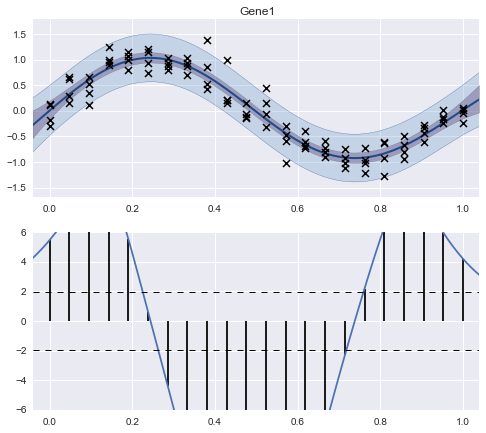

In [8]:
g.plot(inp.rownames[index],mpl.figure(figsize=(8,7)))

with printoptions(precision=5, edgeitems=8, suppress=True):
    print(g.getResults())